# Tutorial 03: Principal Component Analysis

In this tutorial we will learn how to perform principal component analysis (PCA) on a dataset, both in image space and Radon-CDT space. We will also learn how to create figures showing the principal components, modes of variation, and data projections, similar to those found in the optimal transport literature.

This tutorial assumes that you have a basic understanding of PCA, and that you know how to compute the forward and inverse Radon-CDT of an image. If these topics are unfamiliar to you, I suggest that you read Sebastian Raschka's excellent [tutorial on PCA](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html) and our first tutorial on CDT/Radon-CDT transform basics. We will also be using the PCA implementation in *scikit-learn*, the documentation for which can be [found here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

## Import Packages

As always, we need to import some useful packages. We will use the numerical Python package *Numpy* for array manipulation, *matplotlib* for plotting figures, and *scikit-learn* (*sklearn*) to compute the PCA transform. In order to use the *optimaltransport* package later, we must also add the package code to the current Python path (you can skip this step if the *optimaltransport* package has been installed via the pip package manager).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from sklearn.decomposition import PCA

# Add the optrans package to the Python path
# (change the path below to the location of the optimaltransport directory on your computer)
# Note: this step is not necessary if you have installed optimaltransport through pip.
import sys
sys.path.append('../../code/python/optimaltransport')

## PCA in Image Space

In this tutorial, we will first perform PCA on a set of images rather than a set of Radon-CDTs. To do this, we must load some sample data. We will use data from a brain PET study looking at amyloid protein in healthy volunteers and people suffering from Alzheimer's disease. The dataset comprises a 2D axial slice from the brain scans of 264 subjects.

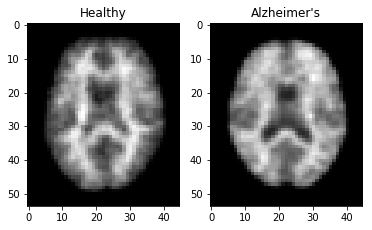

In [19]:
from optrans.datasets import adni

# Load the image data
fpath = '../../code/python/optimaltransport/optrans/datasets/adni_data.npz'
img, label = adni.load_data(fpath=fpath)

# Find the indices of the first healthy volunteer and first Alzheimer's patient
ind_hv = label.argmin()
ind_ad = label.argmax()

# Plot the images
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[ind_hv], cmap='gray')
ax[0].set_title('Healthy')
ax[1].imshow(img[ind_ad], cmap='gray')
ax[1].set_title('Alzheimer\'s')
plt.show()

The `load_data()` function acts as a shorthand for this tutorial, allowing me to quickly load the images and the corresponding patient labels (healthy=0, Alzheimer's=1). Unfortunately, due to copyright restrictions, we are unable to distribute this dataset, but the following analysis can be applied to your own data!

### Perform PCA

In order to perform PCA on our dataset, we must reshape the 2D images into 1D arrays. We can then use *scikit-learn*'s `PCA` class to transform our data. For the purposes of this example, we will only use five PCA components. This will reduce the dimension of our dataset from 54$\times$45=2430 features to just five.

In [20]:
# Get the dimensions of our dataset
n_imgs, h, w = img.shape

# Reshape the 2D images into 1D arrays
img = img.reshape((n_imgs,h*w))

# Initialize PCA
pca = PCA(n_components=5)

# Transform the data and reduce the it to just 5 features
img_pca = pca.fit_transform(img)

### Variance Explained by the Components

The PCA components computed by *scikit-learn* are sorted by the proportion of dataset variance that they explain. For example, the first component will explain the largest variance in the dataset. To highlight this, we can plot the ratio of explained variance for each of our five components.

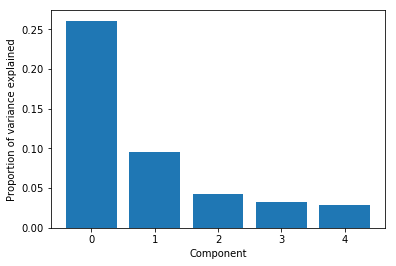

In [21]:
# Get the proportion of variance explained by each component
var_ratio = pca.explained_variance_ratio_

# Plot explained variance
plt.bar(range(5), var_ratio, align='center')
plt.xlabel('Component')
plt.ylabel('Proportion of variance explained')
plt.show()

### Visualize Components

We can make use of the `components_` attribute of the PCA object to plot the computed components. In face recognition tasks in computer vision, these reshaped components are often called "[eigenfaces](https://en.wikipedia.org/wiki/Eigenface)".

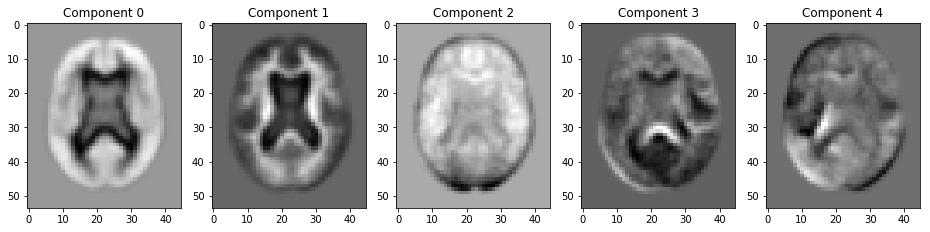

In [22]:
# Plot the first 5 PCA components
_, ax = plt.subplots(1, 5, figsize=(16,4))
for i,a in enumerate(ax):
    # Reshape the component back to 2D
    component = pca.components_[i].reshape((h,w))
    a.imshow(component, cmap='gray')
    a.set_title("Component {}".format(i))
plt.show()

### Modes of Variation

If we consider the first two PCA components, rather than the first five, we can reduce the dimension of our data even further. Moreover, if we reduce our data to just two dimensions, we can plot it on a scatter graph.

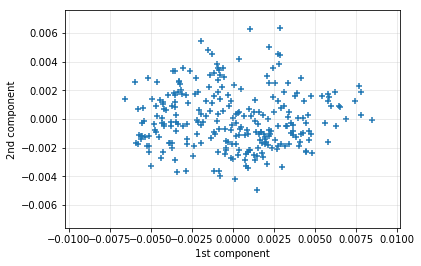

In [24]:
# Plot data projected on to first two components
plt.scatter(img_pca[:,0], img_pca[:,1], marker='+')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.grid(True, alpha=0.3)

# Set the axes limits
lim = 1.2 * np.max(np.abs(img_pca[:,:2]), axis=0)
plt.xlim([-lim[0],lim[0]])
plt.ylim([-lim[1],lim[1]])
plt.show()

In certain applications, it might be useful to visualize images along a particular principal component, to see what dataset variation that particular component captures (e.g. change in brain size, orientation of cells etc.). For example, we might wish to visualize the images that correspond to the red dots along the first principal component (shown below). It should be noted that $\sigma$ is the standard deviation of the data projected on to the first principal component.

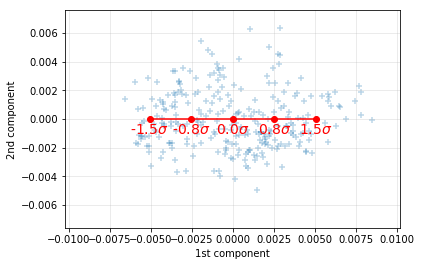

In [53]:
# Get standard deviation of data along 1st component
std0 = np.sqrt(pca.explained_variance_[0])

# Plot data projected on to first two components
plt.scatter(img_pca[:,0], img_pca[:,1], marker='+', alpha=0.3)

# Plot evenly-spaced red dots
std_steps = std0 * np.linspace(-1.5,1.5,5)
plt.plot(std_steps, np.zeros(std_steps.size), marker='o', ls='-', c='r')
for s,r in zip(std_steps,std_range):
    plt.text(s, -0.001, '{:.1f}$\sigma$'.format(r), ha='center', color='r', fontsize=14)

# Axis formatting, as before
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.grid(True, alpha=0.3)
plt.xlim([-lim[0],lim[0]])
plt.ylim([-lim[1],lim[1]])
plt.show()

Using the `get_mode_variation()` function in the *optimaltransport* package, we can visualize the images corresponding to the red dots above. This will give us an indication of how the images vary along the first principal component.

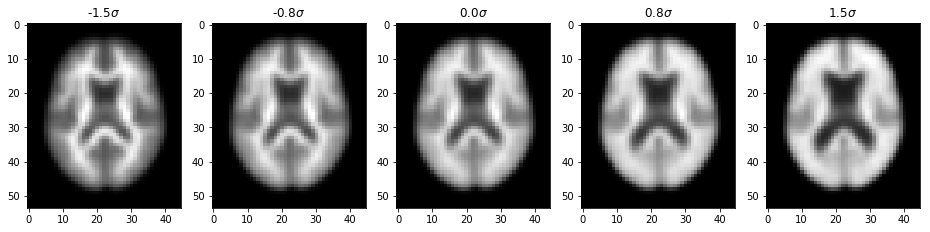

In [54]:
from optrans.decomposition import get_mode_variation

# Set some parameters
component = 0  # Index of the component
n_std = 3.     # Range (in standard deviations) of data along component
n_steps = 5    # Number of steps along the component (i.e. number of images to visualize)

# Get the data variation along the PCA component 
mode = get_mode_variation(pca, component=component, n_std=n_std, n_steps=n_steps)

# The range (in standard deviations) along this component
std_range = np.linspace(-n_std/2, n_std/2, n_steps)

# Plot the results
fig, ax = plt.subplots(1, n_steps, figsize=(16,4))
for m,s,a in zip(mode,std_range,ax):
    img_recon = m.reshape((h,w))
    a.imshow(img_recon, cmap='gray')
    a.set_title("{:.1f}$\sigma$".format(s))
plt.show()

Unsurprisingly, the variation along the first principal component corresponds to the changes in PET brain scans that would be observed as someone transitions from being healthy (above left) to having Alzheimer's disease (above right).

## PCA in Radon-CDT Space

For some applications, it may be beneficial to perform PCA in the optimal transport space. In this example, we will conduct the same analysis as above, but using the Radon-CDTs of the images, rather than the images themselves. Since the Radon-CDT is invertible, and the reference image is known, we can invert the transforms in order to visualize images, not just Radon-CDTs.

As before, let's load some sample data. We will load the transport maps that were computed when performing the Radon-CDT on our brain PET images from earlier. We will also load the reference image `img0` that was used to compute the transport maps.

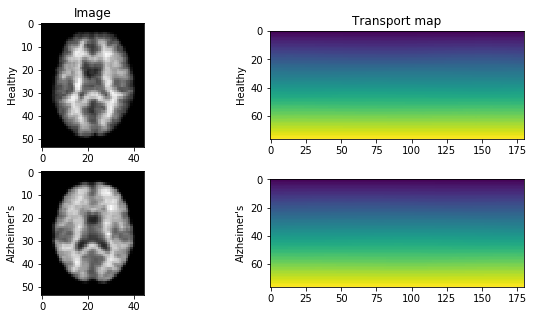

In [55]:
# Load the transport maps corresponding to the images above
fpath = '../../code/python/optimaltransport/optrans/datasets/adni_rcdt_maps.npz'
f, _ = adni.load_rcdt_maps(fpath=fpath)

# Load the reference image that was used to compute the transport maps
fpath = '../../code/python/optimaltransport/optrans/datasets/adni_img0.npy'
img0 = adni.load_img0(fpath=fpath)

# Plot the images and corresponding transport maps
_, ax = plt.subplots(2, 2, figsize=(10,5))
ax[0,0].imshow(img[ind_hv].reshape((h,w)), cmap='gray')
ax[0,0].set_title('Image')
ax[0,0].set_ylabel('Healthy')
ax[0,1].imshow(f[ind_hv])
ax[0,1].set_ylabel('Healthy')
ax[0,1].set_title('Transport map')
ax[1,0].imshow(img[ind_ad].reshape((h,w)), cmap='gray')
ax[1,0].set_ylabel('Alzheimer\'s')
ax[1,1].imshow(f[ind_ad])
ax[1,1].set_ylabel('Alzheimer\'s')
plt.show()

### Perform PCA

In order to use *scikit-learn*'s `PCA` class to transform our data, we must reshape our 2D data into 1D arrays. Using five PCA components, we will reduce the dimension of our data from 77$\times$180=13860 features to just five.

In [56]:
# Get the dimensions of our dataset
n_imgs, h, w = f.shape

# Reshape the 2D transport maps into 1D arrays
f = f.reshape((n_imgs,h*w))

# Initialize PCA
pca = PCA(n_components=5)

# Transform the data and reduce the it to just 5 features
f_pca = pca.fit_transform(f)

### Explained Variance

If we compare the variance explained by the PCA components in transport space and image space, we can see that the in transport space, the first component explains about 40% of the dataset variance, whereas the first component only explains about 25% of the variance in image space. This suggests that PCA in transport space offers a more parsimonious representation of our dataset.

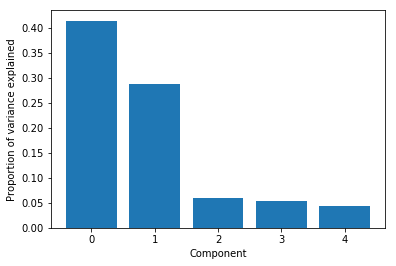

In [57]:
# Get the proportion of variance explained by each component
var_ratio = pca.explained_variance_ratio_

# Plot explained variance
plt.bar(range(5), var_ratio, align='center')
plt.xlabel('Component')
plt.ylabel('Proportion of variance explained')
plt.show()

### Visualizing Components

Once again, we can visualize the top five components in Radon-CDT space.

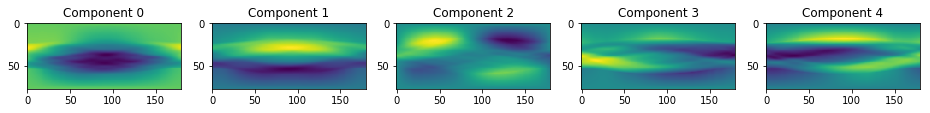

In [58]:
# Plot the first 5 PCA components
_, ax = plt.subplots(1, 5, figsize=(16,4))
for i,a in enumerate(ax):
    # Reshape the component back to 2D
    component = pca.components_[i].reshape((h,w))
    a.imshow(component)
    a.set_title("Component {}".format(i))
plt.show()

### Modes of Variation

If we consider only the first two components, we can plot the data projected in two dimensions.

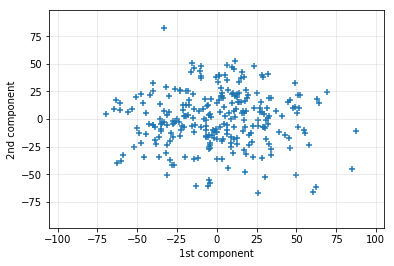

In [59]:
# Plot data projected on to first two components
plt.scatter(f_pca[:,0], f_pca[:,1], marker='+')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.grid(True, alpha=0.3)

# Set the axes limits
lim = 1.2 * np.max(np.abs(f_pca[:,:2]), axis=0)
plt.xlim([-lim[0],lim[0]])
plt.ylim([-lim[1],lim[1]])
plt.show()

Again, using the `get_mode_variation()` function in the *optimaltransport* package, we can visualize the data along the first component (i.e. along the $x$-axis of the figure above). However, this time, we can use the transport maps on the first PCA component to reconstruct the corresponding images. That way, we can assess the variation in the images along a given direction through the data, not just the transport maps.

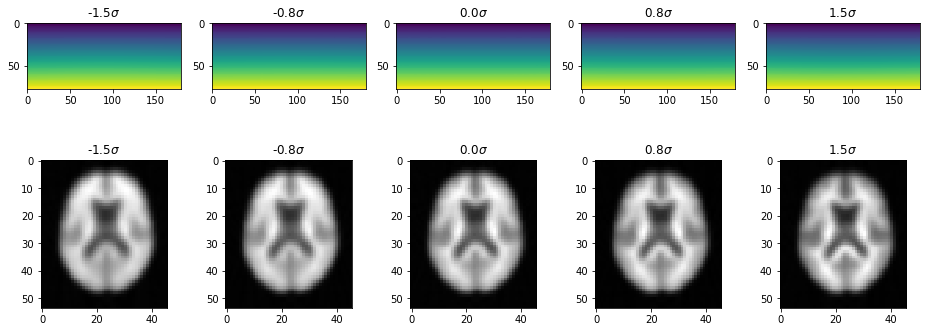

In [62]:
from optrans.continuous import RadonCDT

# Get the data variation along the PCA component 
mode = get_mode_variation(pca, component=0, n_std=n_std, n_steps=n_steps)

# Initialize the RadonCDT so we can apply the inverse transport maps
radoncdt = RadonCDT()

# Plot the results
fig, ax = plt.subplots(2, n_steps, figsize=(16,6))
for i,s in enumerate(std_range):
    # Reshape reconstructed transport map
    f_recon = mode[i].reshape((h,w))
    ax[0,i].imshow(f_recon)
    ax[0,i].set_title("{:.1f}$\sigma$".format(s))
    
    # Reconstruct corresponding image
    img_recon = radoncdt.apply_inverse_map(f_recon, img0)
    ax[1,i].imshow(img_recon, cmap='gray')
    ax[1,i].set_title("{:.1f}$\sigma$".format(s))
    
plt.show()

Since the largest proportion of variance in this dataset is due to the large difference between the PET uptake patterns in healthy and diseased subjects, the images above look very similar to the mode of variation in image space (albeit in the opposite direction). For datasets where the mode of variation is more nuanced, PCA in image space and Radon-CDT space may return different results when considering the reconstructed images.